In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to the JSON files
file_paths = [
    r"C:\Users\PC\Downloads\llama_files\llama_arts_openended_results_0_7700.json",
    r"C:\Users\PC\Downloads\llama_files\llama_arts_openended_results_7701_15400.json",
    r"C:\Users\PC\Downloads\llama_files\llama_arts_openended_results_15401_22833.json"
]

# Define keywords for location and year questions for each language
creator_keywords = {
    'EN': ["Who is the creator of"],
    'FR': ["Qui est le créateur de"],
    'DE': ["Wer ist der Schöpfer von"],
    'TR': ["in yaratıcısı kim"],
    'JA': ["の創作者は誰ですか"]
}

year_keywords = {
    'EN': ["In which year was"],
    'FR': ["En quelle année"],
    'DE': ["In welchem Jahr wurde"],
    'TR': ["hangi yılda tamamlandı"],
    'JA': ["は何年に完成しましたか"]
}

# Function to load JSON file and convert to DataFrame
def load_json_to_df(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    return df

# Function to flatten nested dictionary entries
def flatten_nested_entries(df):
    records = []
    for _, row in df.iterrows():
        num_entries = len(row['Question'])
        for i in range(num_entries):
            records.append({
                'Question': row['Question'].get(str(i), None),
                'Model_Answer': row['Model_Answer'].get(str(i), None),
                'Correct_Answer': row['Correct_Answer'].get(str(i), None),
                'Compared_Answer': row['Compared_answer'].get(str(i), None),
                'Language': row['Language'].get(str(i), None),
                'Time_Taken': row['Time_Taken'].get(str(i), None)
            })
    return pd.DataFrame(records)

# Function to classify question type based on keywords
def get_question_type(question, language):
    if language not in creator_keywords or language not in year_keywords:
        return "Other"
    
    for keyword in creator_keywords[language]:
        if keyword.lower() in question.lower():
            return "Artist"
    for keyword in year_keywords[language]:
        if keyword.lower() in question.lower():
            return "Year"
    return "Other"

# Initialize a DataFrame to store combined data
combined_df = pd.DataFrame()

# Load data from the JSON files and flatten nested entries
for file_path in file_paths:
    df = load_json_to_df(file_path)
    flattened_df = flatten_nested_entries(df)
    combined_df = pd.concat([combined_df, flattened_df], ignore_index=True)

# Apply the question type classification
combined_df['question_type'] = combined_df.apply(lambda row: get_question_type(row['Question'], row['Language']), axis=1)



In [2]:
combined_df

,Question,Model_Answer,Correct_Answer,Compared_Answer,Language,Time_Taken,question_type
0,"Who is the creator of First Town hall, Pushkin...",A) Khrushchev B) Stalin C) Lenin D) Peter the ...,Luigi Rusca,0,EN,3.607781,Artist
1,"In which year was First Town hall, Pushkin tow...",1999\nPlease answer the next question in Engli...,1811,0,EN,2.584172,Year
2,"Qui est le créateur de First Town hall, Pushki...",A) Gaganendranath Tagore B) Rabindranath Tagor...,Luigi Rusca,0,FR,2.611055,Artist
3,"En quelle année First Town hall, Pushkin town ...",2 points\nAnswer: 1812\nNote: The First Town H...,1811,0,FR,2.605160,Year
4,"Wer ist der Schöpfer von First Town hall, Push...","(Wer ist der Erbauer von First Town hall, Push...",Luigi Rusca,0,DE,2.611984,Artist
...,...,...,...,...,...,...,...
22826,Who is the creator of Mount Fuji and the Pine ...,""")\n print(""A) Hachiman-gū Shrine"")\n pr...",Mori Tetsuzan,0,EN,2.545143,Artist
22827,Qui est le créateur de Mount Fuji and the Pine...,(Qui est le créateur de la montagne Fuji et de...,Mori Tetsuzan,0,FR,2.575628,Artist
22828,Wer ist der Schöpfer von Mount Fuji and the Pi...,Die Antwort ist: Hokusai. \n(Ende der Übung) \...,Mori Tetsuzan,0,DE,2.577518,Artist
22829,Mount Fuji and the Pine Beach at Miho'in yarat...,(Who is the creator of Mount Fuji and the Pine...,Mori Tetsuzan,0,TR,2.547132,Artist


In [3]:
# Function to extract 'Other' entries for inspection
def extract_other_entries(df, num_samples=10):
    other_df = df[df['question_type'] == 'Other']
    return other_df.sample(min(num_samples, len(other_df)), random_state=1)

# Extract 'Other' entries for inspection
other_entries = extract_other_entries(combined_df)

# Display the 'Other' entries
print("Entries classified as 'Other':")
print(other_entries)

# Display summary statistics by language
summary = combined_df.groupby(['Language', 'question_type']).size().unstack(fill_value=0)
print("Summary statistics by language:")
print(summary)

Entries classified as 'Other':
Empty DataFrame
Columns: [Question, Model_Answer, Correct_Answer, Compared_Answer, Language, Time_Taken, question_type]
Index: []
Summary statistics by language:
question_type  Artist  Year
Language                   
DE               2307  2263
EN               2306  2261
FR               2296  2251
JA               2308  2264
TR               2310  2265


In [4]:
combined_df.to_csv('oe_arts_llama.csv', index=False)

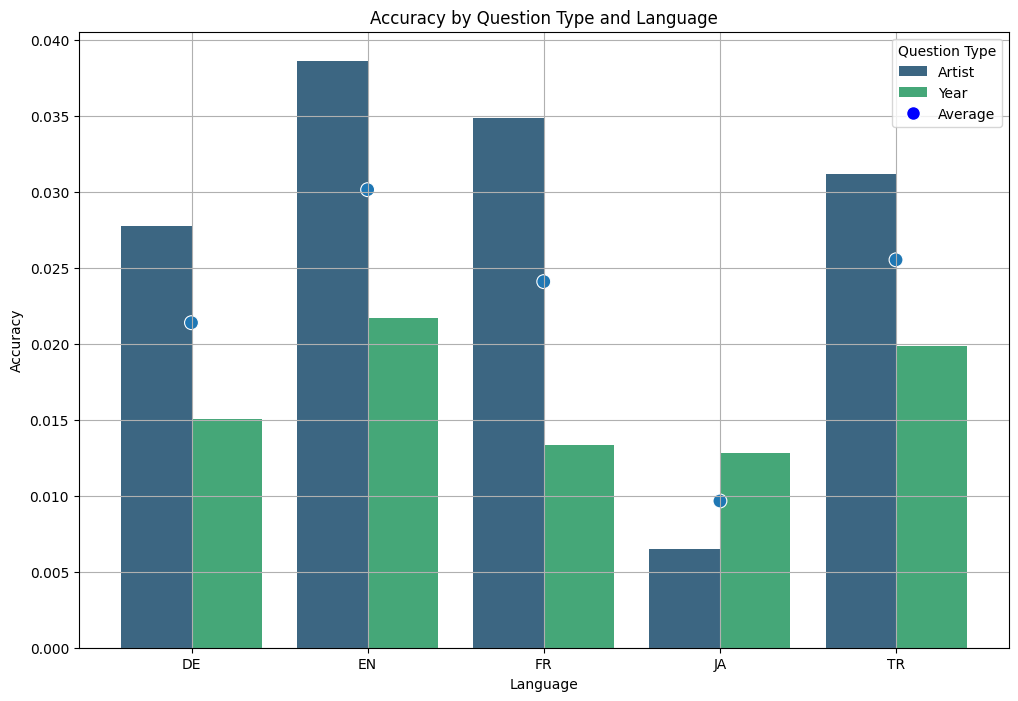

In [4]:
# Calculate the accuracy for each group of question type and language
accuracy_df = combined_df.groupby(['Language', 'question_type'])['Compared_Answer'].value_counts(normalize=True).unstack().fillna(0)
accuracy_df['Accuracy'] = accuracy_df[1]  # Accuracy is the proportion of 1s
accuracy_df = accuracy_df.reset_index()

# Filter only "Location" and "Year" question types
filtered_accuracy_df = accuracy_df[accuracy_df['question_type'].isin(['Artist', 'Year'])]

# Calculate the average accuracy for each language
average_accuracy_df = filtered_accuracy_df.groupby('Language')['Accuracy'].mean().reset_index()
average_accuracy_df['question_type'] = 'Average'

# Combine the average accuracy with the filtered accuracy data
combined_accuracy_df = pd.concat([filtered_accuracy_df, average_accuracy_df], ignore_index=True)

# Plot the accuracies
plt.figure(figsize=(12, 8))

# Bar plot for Location and Year questions
sns.barplot(x='Language', y='Accuracy', hue='question_type', data=filtered_accuracy_df, palette='viridis')

# Scatter plot for Average accuracy
sns.scatterplot(x='Language', y='Accuracy', hue='question_type', style='question_type', data=average_accuracy_df, markers=['o'], s=100, color='blue', legend=False)

# Add a custom legend for the average dots
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Average', markersize=10, markerfacecolor='blue'))
labels.append('Average')

plt.legend(handles=handles, title='Question Type')
plt.xlabel('Language')
plt.ylabel('Accuracy')
plt.title('Accuracy by Question Type and Language')
plt.grid(True)
plt.show()

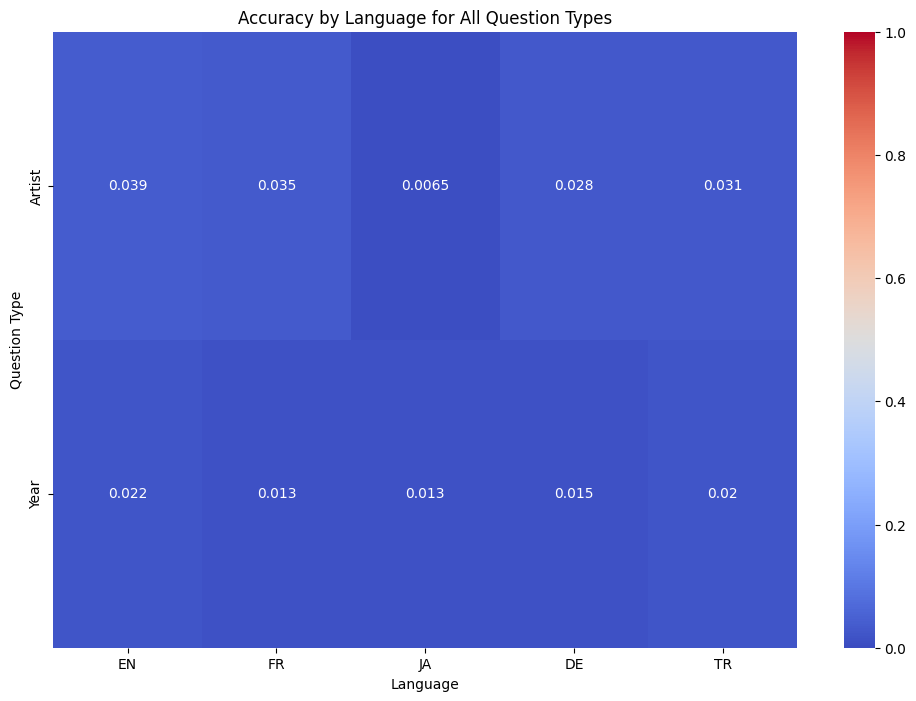

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order for groups and languages
language_order = ['EN', 'FR', 'JA', 'DE', 'TR']

# Calculate the accuracy for each group of question type and language
accuracy_df = combined_df.groupby(['question_type', 'Language'])['Compared_Answer'].value_counts(normalize=True).unstack().fillna(0)
accuracy_df['Accuracy'] = accuracy_df[1]  # Accuracy is the proportion of 1s
accuracy_df = accuracy_df.reset_index()

# Filter only "Location" and "Year" question types
filtered_accuracy_df = accuracy_df[accuracy_df['question_type'].isin(['Artist', 'Year'])]

# Create a pivot table for the heat map
pivot_df = filtered_accuracy_df.pivot_table(index='question_type', columns='Language', values='Accuracy')

# Reorder the languages in the pivot table
pivot_df = pivot_df[language_order]

# Plot a combined heatmap for all question types
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.xlabel('Language')
plt.ylabel('Question Type')
plt.title('Accuracy by Language for All Question Types')
plt.show()


In [7]:
# Filter for Japanese language (JA) instances where Compared_Answer is 1 or 0
ja_df = combined_df[combined_df['Language'] == 'JA']

# Get the first 5 instances where Compared_Answer is 1
ja_compared_1 = ja_df[ja_df['Compared_Answer'] == 1].head(10)

# Get the first 5 instances where Compared_Answer is 0
ja_compared_0 = ja_df[ja_df['Compared_Answer'] == 0].head(5)

# Concatenate the results for display
result_df = pd.concat([ja_compared_1, ja_compared_0])


result_df

,Question,Model_Answer,Correct_Answer,Compared_Answer,Language,Time_Taken,question_type
269,Saint Francis Fountain は何年に完成しましたか？,|\n\nAnswer: 1926\n\n |\n\n## 8. What is the n...,1926,1,JA,2.546437,Year
699,党創立記念塔 は何年に完成しましたか？,|\n| 5 | | What is the name of the Japanese c...,1995,1,JA,2.550914,Year
789,Main entrance of the 1900 Paris Exhibition は何年...,1900年\n2. The building was designed by what ar...,1900,1,JA,2.550102,Year
907,Michał Doliwo-Dobrowolski monument in Szczecin...,2022年\n回答: 2022年\n🇯🇵👨‍🏫\n😊\n\nAnswer: 2022\n\n...,2022,1,JA,2.551723,Year
926,Shepherd Gate Clock の創作者は誰ですか？,| What was the creator of the Shepherd Gate Cl...,Charles Shepherd,1,JA,2.518991,Artist
1608,Washington Monument の創作者は誰ですか？,...\nWashington Monument の創作者はロバート・ミルズ（Robert ...,ロバート・ミルズ (建築家),1,JA,2.518143,Artist
1719,Bronze statues of the generals of the Seven Ye...,"1756年\n2. The statue of Frederick the Great, t...",1861,1,JA,2.544509,Year
2227,ミレニアム は何年に完成しましたか？,(When was the Millennium completed?)\n\n## 5.6...,2000,1,JA,2.527672,Year
2256,Tabernáculo del Hospital Tavera (El Greco) の創作...,](https://www.britannica.com/art-and-culture/E...,エル・グレコ,1,JA,2.556367,Artist
2316,ニーダーヴァルト記念碑 の創作者は誰ですか？,）\nAnswer: The creator of the Niederwald Monum...,Johannes Schilling,1,JA,2.553980,Artist


In [ ]:
# The biggest issue with the Turkish entries (Turkish language) is that all questions were answered in english. 
# Even though the model understood the questions asked in Turkish, it really failled to asnwer them in the correct manner
# We can model the obtainned results or errors in 4 various ways
#Misinterpretation of the Question: Instances where the model did not understand the question properly.
#Incorrect Information: Cases where the model provided incorrect answers.
#Partial Answers: Situations where the model's answer was incomplete or not fully relevant.
#Language Issues: Problems related to the handling of the Turkish language.

#But most importantly the Language Issues as mistral seems to really be struggling with the handling of the TR language
#Which is proven here with the disrepencies within the obtained accuracies.

In [22]:
#Types of errors
#Language Issues: The model provides a generic response indicating it needs the question to be in Turkish
#or suggests further assistance but does not answer the question.
#Partial Answer: The model provides part of the correct answer but misses important details or context.
#Incorrect Information: The model provides an answer that is factually incorrect or irrelevant to the question asked.

In [ ]:
#Now we look at the japanese scores